<a href="https://colab.research.google.com/github/sztahodavid/humanaicourse/blob/main/emotion_recognition_speech_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Érzelemfelismerés beszédet leíró manuális jellemzőkkel

Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges.

Az első lépés a *szükséges csomagok* betöltése.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE
from tqdm import tqdm

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltároljuk a *labels* változóban.

In [2]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2024-11-24 12:37:06--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip’

HungarianEmotionalS 100%[===================>]  59.70M  5.69MB/s    in 11s     

2024-11-24 12:37:18 (5.68 MB/s) - ‘HungarianEmotionalSentences.zip’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
  inflating: readme.txt              
  inflating: F0001B_hu.wav           
  inflating: F0001D_hu.wav           
  inflating: F0001I_hu.wav           
  inflating: F0001L_hu.wav           
  inflating: F0001M_hu.wav           
  inflating: F0001O_hu.wav           
  inflating: F0001S_hu.wav           
  inflating: F0002B_hu.wav           
  inflating: F0002D_hu.wav           
  inflating: F0002F_hu.wav  

In [4]:
DATA_PATH = "/content/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]
labels = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])

A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [5]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

A jellemzőkinyerésre a **surfboard** csomagot használjuk. Itt megadhatjuk, hogy mely beszédet leíró jellemzőkre van szükségünk. Ez ebben az esetben az *MFCC* értékek átlaga és szórás a teljes beszédfelvételre nézve. A surfboard bemenete maguk a handfelvételek.

In [14]:
X = pd.DataFrame()
for file in tqdm(file_paths):
    y, sr = librosa.load(path=file)
    feature_dataframe = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feature_dataframe = np.mean(feature_dataframe, axis = -1)
    X = pd.concat([X,pd.DataFrame(feature_dataframe).T],ignore_index=True)
    # X = X.append(pd.DataFrame(feature_dataframe).T)

100%|██████████| 262/262 [00:08<00:00, 31.18it/s]


A kapott jellemzőket standarizáljuk (z = (x - átlag) / szórás) és eltároljuk az *X* változóban. A címkéket egy *y* tömbben tároljuk el.

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = np.array(labels)

In [16]:
X

array([[-0.01713448,  0.8078284 ,  0.35732383, ...,  0.3308427 ,
        -0.33190998, -0.6965412 ],
       [-1.3000625 , -0.08035026,  0.7726874 , ...,  1.032886  ,
        -0.32767564, -0.71696424],
       [-1.8385317 , -0.23424898,  1.0676751 , ...,  0.7417404 ,
         0.6811766 , -0.24565525],
       ...,
       [ 1.3159957 ,  0.3145953 ,  0.2513261 , ...,  0.7174164 ,
        -0.03728125,  1.003286  ],
       [ 0.22789857,  0.5384102 , -0.00372569, ...,  0.45487314,
        -0.62999684,  0.38268384],
       [ 1.09786   ,  0.3475774 ,  0.50257355, ...,  0.3917099 ,
        -0.6831139 ,  0.54832   ]], dtype=float32)

Support Vektor Gép modellt fogunk taníani és tesztelni. Ehhez teljes keresztvalidációs eéjárást alkalmazunk, ahol mindig egy elem a teszt elem, a maradék pedig a tanító halmaz. Ez ismétlődik, amíg az összes elem nem volt tesztelem. Tesztelés során  a minta eredeti címkéjét (*orig*) és a bescült címkét (*pred*) eltároljuk.

In [17]:
loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', C = 1, probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

Végül egy *tévesztési mátrixon* és egy *reporton* keresztül vizsgálhatjuk a modellek teljesítményét.

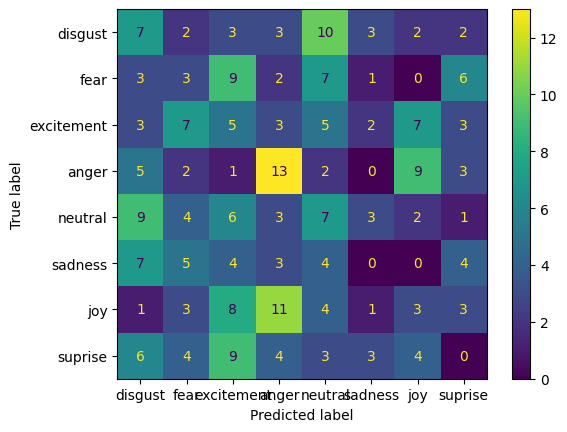

In [18]:
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [19]:
print(metrics.classification_report(orig, pred, target_names=list(set(labels))))

              precision    recall  f1-score   support

     disgust       0.31      0.37      0.34        35
        fear       0.17      0.22      0.19        32
  excitement       0.11      0.14      0.12        35
       anger       0.10      0.10      0.10        31
     neutral       0.11      0.09      0.10        34
     sadness       0.17      0.20      0.18        35
         joy       0.00      0.00      0.00        27
     suprise       0.00      0.00      0.00        33

    accuracy                           0.15       262
   macro avg       0.12      0.14      0.13       262
weighted avg       0.13      0.15      0.13       262



Vizuális betekintést tehetünk a jellemzők szeparációs képességébe úgy, hogy dimenziójukat lecsökkentjük (ábrázolható mennyiségre) a minták egymáshoz képesti távolságuk megtartása mellett (t-SNE: t-distributed stochastic neighbor embedding). Az ábrázoláshoz az érzelmeket színkódoljuk egy szótár segítségével.

(-39.78221759796143, 37.96450290679932, -57.6308931350708, 57.07039585113525)

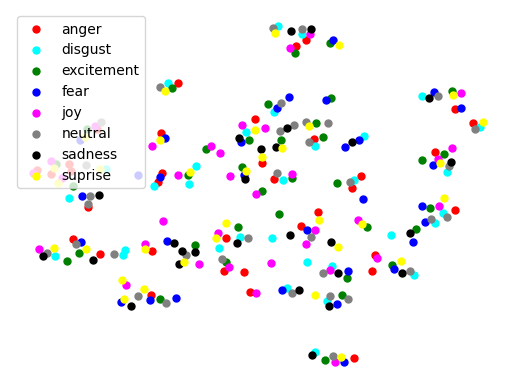

In [20]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('off')